# Segmenting remote sensing imagery with text prompts and the Segment Anything Model (SAM)

This notebook shows how to generate object masks from text prompts with the Segment Anything Model (SAM).

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
%pip install segment-geospatial groundingdino-py leafmap localtileserver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 630.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.3 MB/s eta 0

In [2]:
%pip install localtileserver

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [30]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

You can also use your own image. Uncomment and run the following cell to use your own image.

In [43]:
image = '/content/drive/MyDrive/Costal_Areas/Barragem_de_Alqueva_Portugal.tif'
# image = '/content/drive/MyDrive/Costal_Areas/usa_Glen_Canyon_Dam_grid_station.tif'
# image = '/content/drive/MyDrive/Costal_Areas/07-2006-Normandy.tif'

Display the downloaded image on the map.

## Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [32]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


## Specify text prompts

In [33]:
# urban areas
# grid stations 35.00

In [98]:
text_prompt = "water"

## Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [99]:
sam.predict(image, text_prompt, box_threshold=0.35, text_threshold=0.35, output="test.tif")

In [100]:
# sam.predict_dino(image, text_prompt, box_threshold=0.30, text_threshold=0.30, output="test.tif")

In [101]:
sam.raster_to_vector("test.tif", "test.shp")

In [102]:
import shapefile
from json import dumps

In [103]:
# read the shapefile
reader = shapefile.Reader("/content/test.shp")
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []

for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    atr['label'] = text_prompt
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature",geometry=geom, properties=atr))

In [104]:
# write the GeoJSON file
geojson = open("eez_boundaries.json", "w")
geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
geojson.close()

## Visualize the results

Show the result with bounding boxes on the map.

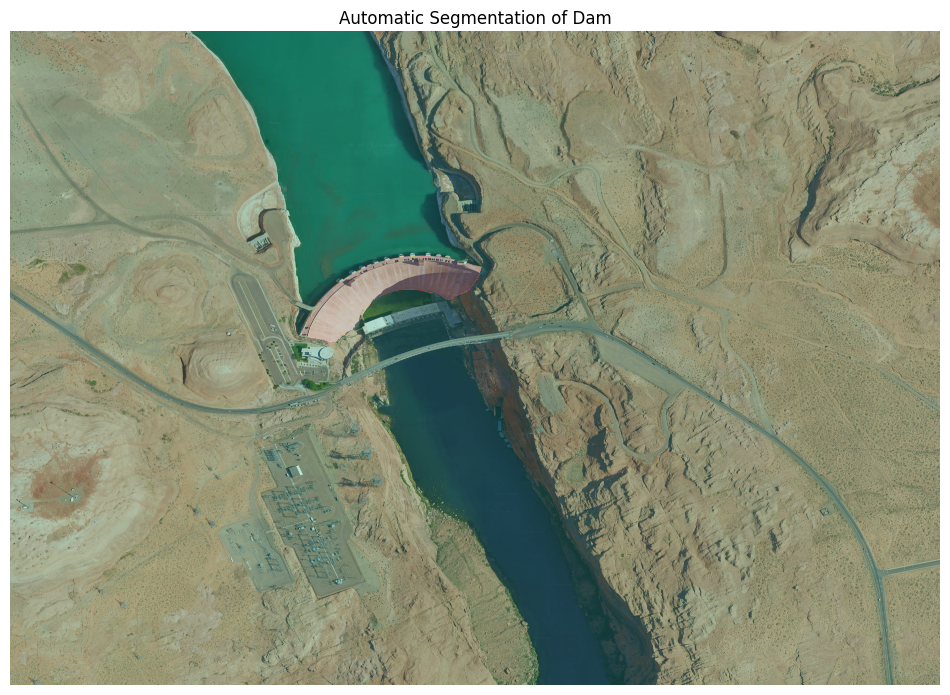

In [ ]:
sam.show_anns(
    cmap='Dark2',
    add_boxes=False,
    alpha=0.3,
    title='Automatic Segmentation of Dam',
)

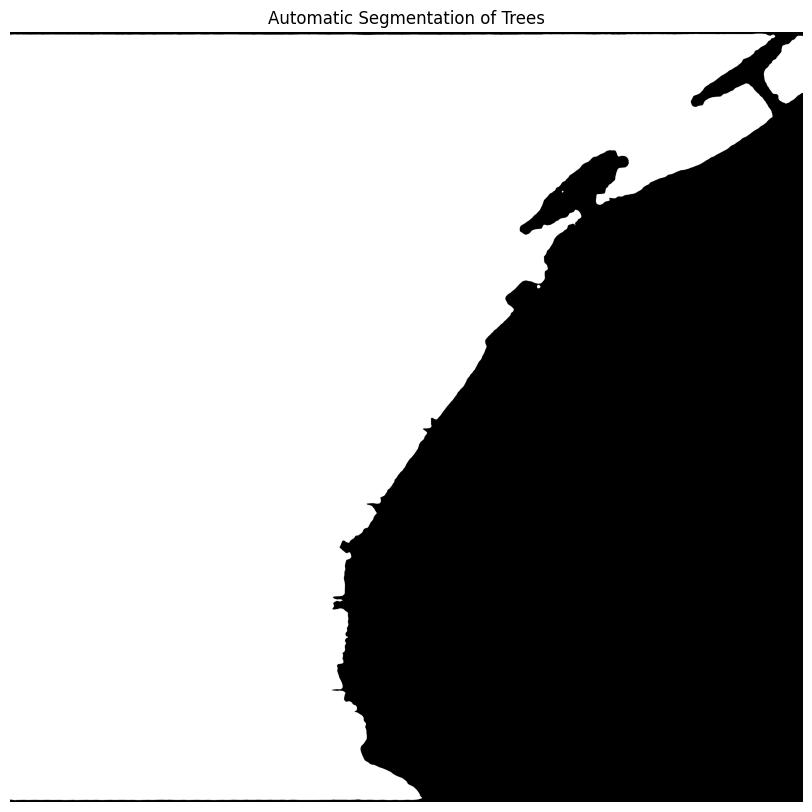

In [ ]:
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title='Automatic Segmentation of Trees',
    blend=False,
    output='trees.tif',
)

In [ ]:
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Automatic Segmentation of Trees',
    blend=True,
)

![](https://i.imgur.com/ytKMTlA.png)

Show the result without bounding boxes on the map.

![](https://i.imgur.com/3Iq2kt1.png)

Show the result as a grayscale image.

![](https://i.imgur.com/KtHwFbF.png)

Convert the result to a vector format.  

Show the results on the interactive map.

In [ ]:
m.add_raster("trees.tif", layer_name="Trees", palette="Greens", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("trees.shp", layer_name="Vector", style=style)
m

## Interactive segmentation

In [ ]:
sam.show_map()

![](https://i.imgur.com/wydt5Xt.gif)